<a href="https://colab.research.google.com/github/Abonia1/Abusive-Language-Detection/blob/master/Computer_Vision_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Computer Vision with PyTorch’s TorchVision**
TorchVision is PyTorch’s own computer vision library which contains many important and useful datasets as well as models and transformation operations that are often used in the area of computer vision.

This notebook will show a basic data exploration of a very famous dataset known as the Fashion MNIST dataset using PyTorch’s TorchVision library.

## **Import Packages**
Import Necessary packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

## Load Dataset
Fashion MNIST dataset comes built-in with the torchvision package..

Now we make an instance of the Fashion MNIST dataset calling it “train_set” using torchvision in the following way:

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
train_loader = torch.utils.data.DataLoader(train_set
    ,batch_size=1000
    ,shuffle=True
)

## Explore the Dataset

**check how many images we have in our train_set**

In [4]:
len(train_set)

60000

In [5]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [6]:
train_set.targets.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

We can see that we have 10 target values and they have equal distribution within them. So class are balanced.

In [7]:
sample = next(iter(train_set))
len(sample)        
type(sample)  

tuple

In [8]:
image, label = sample
image = sample[0]
label = sample[1]

**Now we can check the type and shape of image and label individually.**

In [9]:
type(image)                  


torch.Tensor

In [10]:
type(label)

int

In [11]:
image.shape                  
torch.tensor(label).shape    
image.squeeze().shape  

torch.Size([28, 28])

## Visualize the image

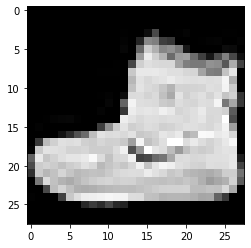

In [12]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")

In [13]:
torch.tensor(label)

tensor(9)

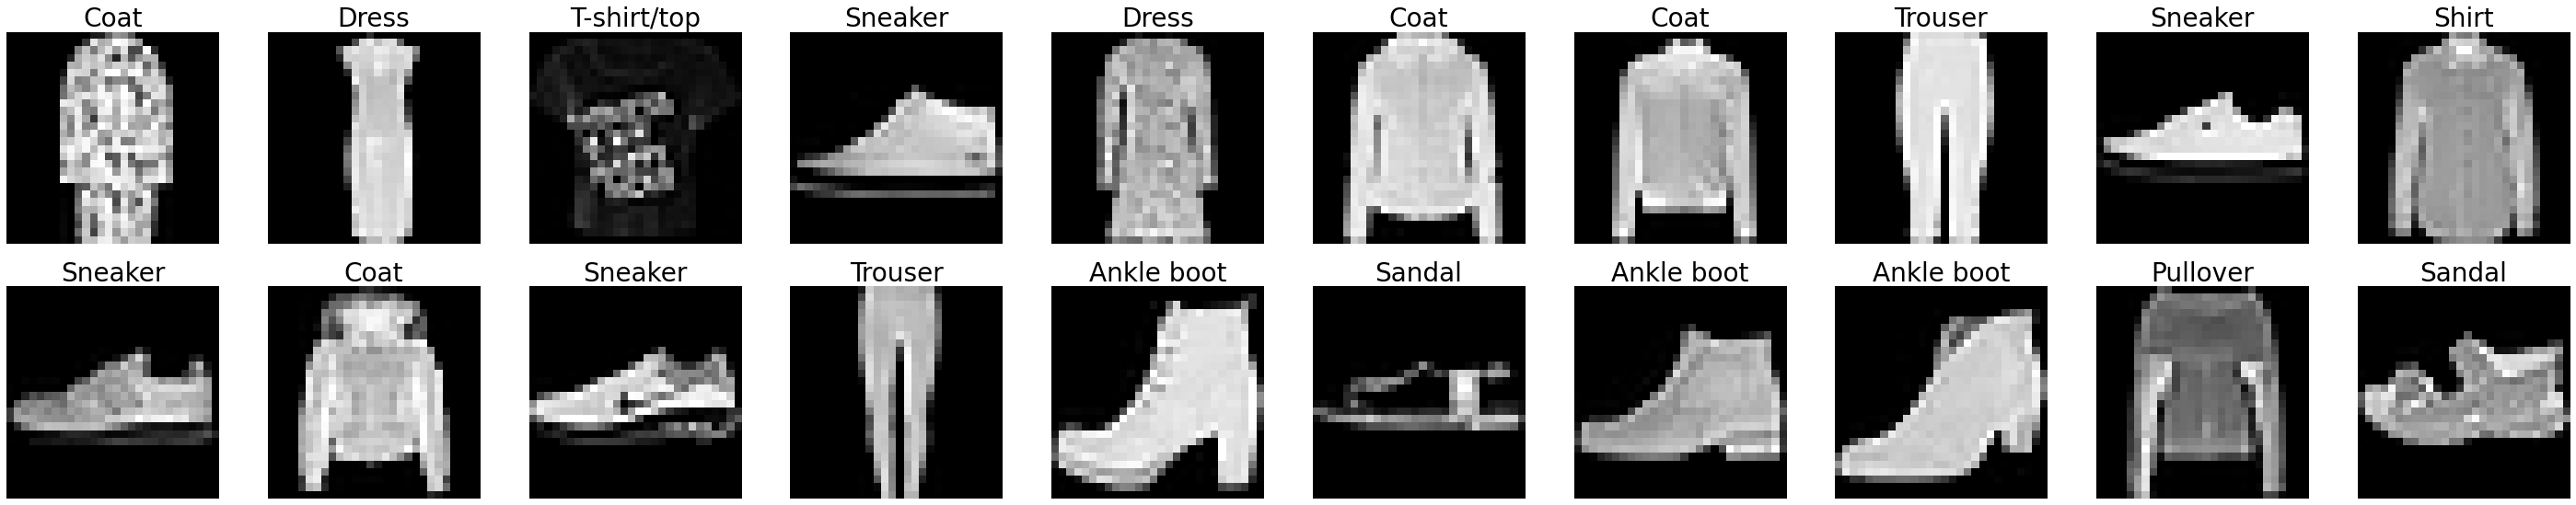

In [14]:
how_many_to_plot = 20

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True
)

plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    plt.imshow(image.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.title(train_set.classes[label.item()], fontsize=28)
    if (i >= how_many_to_plot): break
plt.show()

### Define the hyperparameters

In [15]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [18]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/train-images-idx3-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /files/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /files/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /files/FashionMNIST/raw



In [19]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [20]:
example_data.shape

torch.Size([1000, 1, 28, 28])

## Building the Network

In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We'll use two 2-D convolutional layers followed by two fully-connected (or linear) layers. As activation function we'll choose rectified linear units (ReLUs in short) and as a means of regularization we'll use two dropout layers. In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. 

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Broadly speaking we can think of the torch.nn layers as which contain trainable parameters while torch.nn.functional are purely functional. The forward() pass defines the way we compute our output using the given layers and functions. It would be perfectly fine to print out tensors somewhere in the forward pass for easier debugging. This comes in handy when experimenting with more complex models. Note that the forward pass could make use of e.g. a member variable or even the data itself to determine the execution path - and it can also make use of multiple arguments!

In [24]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

### Training the Model
First we want to make sure our network is in training mode. Then we iterate over all training data once per epoch. Loading the individual batches is handled by the DataLoader. First we need to manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients. We then produce the output of our network (forward pass) and compute a negative log-likelihodd loss between the output and the ground truth label. The backward() call we now collect a new set of gradients which we propagate back into each of the network's parameters using optimizer.step(). For more detailed information about the inner workings of PyTorch's automatic gradient system, see the official docs for autograd 

In [25]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [39]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/roptimizer.pth')

In [40]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [42]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8288, Accuracy: 7081/10000 (71%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.858629
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.914645
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.883459
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.786227
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.178739
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.921950
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.997526
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.956169
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.900803
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.150420
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.057913
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.239937
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.902461
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.840518
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.926559
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.969651
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.166016
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.965748
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.050037
Train Epoch: 1 [12160

### Evaluating the Model's Performance

ValueError: ignored

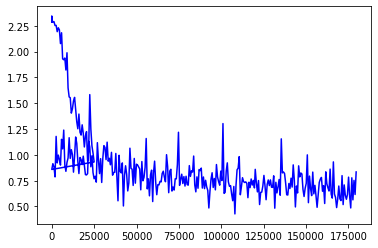

In [43]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [44]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


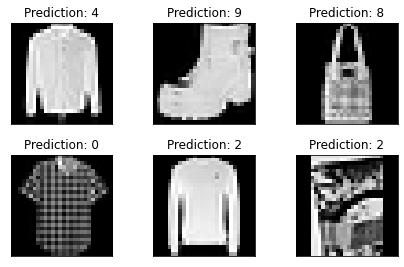

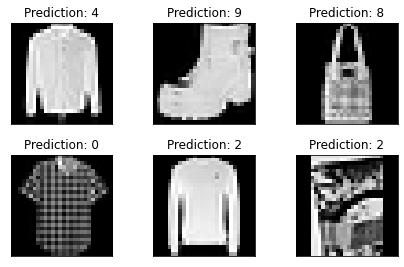

In [45]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

## Training from Checkpoints

In [46]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [48]:
network_state_dict = torch.load('/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/roptimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

Again running a training loop should immediately pick up the training where we left it. To check on that let's simply use the same lists as before to keep track of the loss values. Due to the way we constructed the test counter for the number of training examples seen we manually have to append to it here.

In [49]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.491730
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.660734
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.554329
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.637817
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.550775
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.474983
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.484970
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.838969
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.769691
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.649975
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.535424
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.662785
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.631885
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.454401
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.708929
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.686025
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.777279
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.779945
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.524507
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.503018
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5121, Accuracy: 8012/10000 (80%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.575857
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.604882
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.705416
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.597187
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.524921
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.714810
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.743932
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.639588
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.799018
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.735140
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.629761
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.544144
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.560804
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.708965
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.595841
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.767248
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.478448
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.698223
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.552853
Train Epoch: 5 [12160

ValueError: ignored

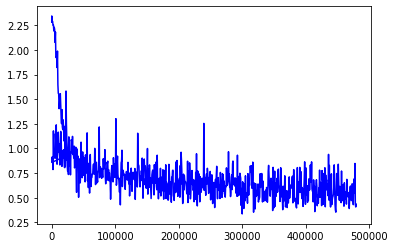

In [50]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

# Conclusion
The model performance can be improved by training for longer as we dont find the overfitting isssues from the model result.

We built a new environment with PyTorch and TorchVision, used it to classifiy fashion product from the MNIST dataset and hopefully developed a good intuition using PyTorch. For further information the official [PyTorch documentation](https://pytorch.org/docs/stable/index.html) is really nicely written and the [forums](https://discuss.pytorch.org/) are also quite active!

# Reference

[1] MNIST Handwritten Digit Recognition in PyTorch(Feb 17th, 2020): https://nextjournal.com/gkoehler/pytorch-mnist

[2] PyTorch official documentation : https://pytorch.org/docs/stable/index.html

[3] MNIST Fashion Datset : https://github.com/zalandoresearch/fashion-mnist

[4] Intro to Computer Vision with PyTorch’s TorchVision : https://blog.jovian.ai/intro-to-computer-vision-with-pytorchs-torchvision-46c4ff43ce34